In [19]:
import yfinance as yf
import numpy as np
import torch
import seaborn as sns
sns.set()

from torch import nn

In [2]:
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
START = datetime(1990,1,1)
END = datetime(2020,6,5)

UVXY = yf.Ticker('UVXY')
hist = UVXY.history(start=START, end=END)
hist.drop(['Volume', 'Dividends', 'Stock Splits'], axis=1, inplace=True)

In [4]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [5]:
hist['RET'] = hist['Close'].pct_change()
hist.dropna(inplace=True)
hist['y'] = hist['RET'].rolling(10).sum()
hist['y_binary'] = (hist['y'] > 0).astype(int)
hist['y'] = hist['y'].shift(-9)
hist['y_binary'] = hist['y_binary'].shift(-9)
hist.dropna(inplace=True)
hist

,Open,High,Low,Close,RET,y,y_binary
Date,,,,,,,
2011-10-05,1.974600e+08,1.989000e+08,1.813800e+08,1.813800e+08,-0.118659,-0.405426,0.0
2011-10-06,1.811400e+08,1.878000e+08,1.740000e+08,1.740000e+08,-0.040688,-0.175707,0.0
2011-10-07,1.705800e+08,1.857600e+08,1.684800e+08,1.765200e+08,0.014483,-0.133360,0.0
2011-10-10,1.654800e+08,1.656000e+08,1.559400e+08,1.559400e+08,-0.116587,-0.249292,0.0
2011-10-11,1.570200e+08,1.572600e+08,1.491000e+08,1.506000e+08,-0.034244,-0.254364,0.0
...,...,...,...,...,...,...,...
2020-05-15,4.358000e+01,4.461000e+01,3.919000e+01,3.923000e+01,-0.037301,-0.176722,0.0
2020-05-18,3.529000e+01,3.643000e+01,3.466000e+01,3.544000e+01,-0.096610,-0.131081,0.0
2020-05-19,3.565000e+01,3.817000e+01,3.449000e+01,3.800000e+01,0.072235,-0.074649,0.0


In [6]:
in_seq1 = np.array(hist['Open'].values.reshape(-1,1))
in_seq2 = np.array(hist['High'].values.reshape(-1,1))
in_seq3 = np.array(hist['Low'].values.reshape(-1,1))
in_seq4 = np.array(hist['Close'].values.reshape(-1,1))


In [7]:
out_seq = np.array(hist['y'].values.reshape(-1,1))
out_seq_bin = np.array(hist['y_binary'].values.reshape(-1,1))

In [8]:
dataset = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, out_seq))
dataset_binary = np.hstack((in_seq1, in_seq2, in_seq3, in_seq4, out_seq_bin))

In [9]:
class MV_LSTM(nn.Module):
    def __init__(self, n_features, seq_length, hidden_dim=20, num_layers=1, binary=False):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_length = seq_length
        self.n_hidden = hidden_dim
        self.n_layers = num_layers
        self.binary = binary

        self.lstm = nn.LSTM(input_size=self.n_features,
                            hidden_size=self.n_hidden,
                            num_layers=self.n_layers,
                            batch_first=True)
        self.linear = nn.Linear(self.n_hidden*self.seq_length, 1)

    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.n_layers, batch_size, self.n_hidden)
        cell_state = torch.zeros(self.n_layers, batch_size, self.n_hidden)
        self.hidden = (hidden_state, cell_state)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        lstm_out, self.hidden = self.lstm(x, self.hidden)
        x = lstm_out.contiguous().view(batch_size, -1)
        pred = self.linear(x)
        if self.binary:
            pred = torch.sigmoid(pred)
        return pred
        

In [10]:
MV_LSTM(4, 10, 20, 2)

MV_LSTM(
  (lstm): LSTM(4, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=200, out_features=1, bias=True)
)

## Binary Cross Entropy Loss with binary prediction

In [11]:
n_features = 4
n_timesteps = 30

X, y = split_sequence(dataset_binary, n_timesteps)
print(X.shape, y.shape)

(2142, 30, 4)(2142,)


In [12]:
mv_net = MV_LSTM(n_features, n_timesteps, num_layers=2, binary=True)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-2)

train_episodes = 20
batch_size = 16

In [13]:
mv_net.train()
train_loss = []
val_loss = []

for t in range(train_episodes):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1)
    optimizer.zero_grad()
    for b in range(0, len(train_X), batch_size):
        inpt = train_X[b:b+batch_size, :, :]
        target = train_y[b:b+batch_size]

        x_batch = torch.tensor(inpt, dtype=torch.float32)
        y_batch = torch.tensor(target, dtype=torch.float32)

        mv_net.init_hidden(x_batch.size(0))
        output = mv_net(x_batch)

        loss_train = criterion(output.view(-1), y_batch)
        loss_train.backward()

        optimizer.step()

    for b in range(0, len(test_X), batch_size):
        inpt = test_X[b:b+batch_size, :, :]
        target = test_y[b:b+batch_size]

        x_batch = torch.tensor(inpt, dtype=torch.float32)
        y_batch = torch.tensor(target, dtype=torch.float32)

        mv_net.init_hidden(x_batch.size(0))
        output = mv_net(x_batch)
        loss_val = criterion(output.view(-1), y_batch)

    train_loss.append(loss_train.item())
    val_loss.append(loss_val.item())
    print("Step: {} Train Loss: {} Val Loss: {}".format(t+1, round(loss_train.item(), 4), round(loss_val.item(), 4)))



Step: 1 Train Loss: 0.5987 Val Loss: 0.9654
Step: 2 Train Loss: 0.6839 Val Loss: 0.6838
Step: 3 Train Loss: 0.7441 Val Loss: 0.5994
Step: 4 Train Loss: 0.6577 Val Loss: 0.6076
Step: 5 Train Loss: 0.255 Val Loss: 0.7863
Step: 6 Train Loss: 0.6611 Val Loss: 0.6177
Step: 7 Train Loss: 0.4225 Val Loss: 0.6179
Step: 8 Train Loss: 0.6751 Val Loss: 0.6776
Step: 9 Train Loss: 0.6106 Val Loss: 0.4278
Step: 10 Train Loss: 0.7118 Val Loss: 0.6843
Step: 11 Train Loss: 0.9396 Val Loss: 0.4363
Step: 12 Train Loss: 0.7267 Val Loss: 0.6829
Step: 13 Train Loss: 0.7544 Val Loss: 0.7563
Step: 14 Train Loss: 0.5314 Val Loss: 0.634
Step: 15 Train Loss: 0.8867 Val Loss: 0.5993
Step: 16 Train Loss: 0.6126 Val Loss: 0.581
Step: 17 Train Loss: 0.7721 Val Loss: 0.6053
Step: 18 Train Loss: 0.6829 Val Loss: 0.683
Step: 19 Train Loss: 0.7678 Val Loss: 1.1012
Step: 20 Train Loss: 0.65 Val Loss: 0.6202


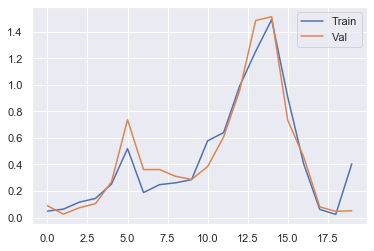

In [20]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Train', 'Val'])

## MSE Loss with returns prediction

In [15]:
n_features = 4
n_timesteps = 30

X, y = split_sequence(dataset, n_timesteps)
print(X.shape, y.shape)

(2142, 30, 4)(2142,)


In [16]:
mv_net = MV_LSTM(n_features, n_timesteps, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-2)

train_episodes = 20
batch_size = 16

In [17]:
mv_net.train()
train_loss = []
val_loss = []

for t in range(train_episodes):
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1)
    optimizer.zero_grad()
    for b in range(0, len(train_X), batch_size):
        inpt = train_X[b:b+batch_size, :, :]
        target = train_y[b:b+batch_size]

        x_batch = torch.tensor(inpt, dtype=torch.float32)
        y_batch = torch.tensor(target, dtype=torch.float32)

        mv_net.init_hidden(x_batch.size(0))
        output = mv_net(x_batch)

        loss_train = criterion(output.view(-1), y_batch)
        loss_train.backward()

        optimizer.step()

    for b in range(0, len(test_X), batch_size):
        inpt = test_X[b:b+batch_size, :, :]
        target = test_y[b:b+batch_size]

        x_batch = torch.tensor(inpt, dtype=torch.float32)
        y_batch = torch.tensor(target, dtype=torch.float32)

        mv_net.init_hidden(x_batch.size(0))
        output = mv_net(x_batch)
        loss_val = criterion(output.view(-1), y_batch)

    train_loss.append(loss_train.item())
    val_loss.append(loss_val.item())
    print("Step: {} Train Loss: {} Val Loss: {}".format(t+1, round(loss_train.item(), 4), round(loss_val.item(), 4)))



Step: 1 Train Loss: 0.0485 Val Loss: 0.0892
Step: 2 Train Loss: 0.0636 Val Loss: 0.0258
Step: 3 Train Loss: 0.1161 Val Loss: 0.074
Step: 4 Train Loss: 0.144 Val Loss: 0.1047
Step: 5 Train Loss: 0.252 Val Loss: 0.2692
Step: 6 Train Loss: 0.5191 Val Loss: 0.7366
Step: 7 Train Loss: 0.1883 Val Loss: 0.3612
Step: 8 Train Loss: 0.2478 Val Loss: 0.3614
Step: 9 Train Loss: 0.2614 Val Loss: 0.3103
Step: 10 Train Loss: 0.2854 Val Loss: 0.2874
Step: 11 Train Loss: 0.5774 Val Loss: 0.3836
Step: 12 Train Loss: 0.6396 Val Loss: 0.6078
Step: 13 Train Loss: 0.9897 Val Loss: 0.9561
Step: 14 Train Loss: 1.2514 Val Loss: 1.4837
Step: 15 Train Loss: 1.4905 Val Loss: 1.512
Step: 16 Train Loss: 0.9084 Val Loss: 0.7333
Step: 17 Train Loss: 0.403 Val Loss: 0.4566
Step: 18 Train Loss: 0.0615 Val Loss: 0.0803
Step: 19 Train Loss: 0.0236 Val Loss: 0.0467
Step: 20 Train Loss: 0.4046 Val Loss: 0.0513


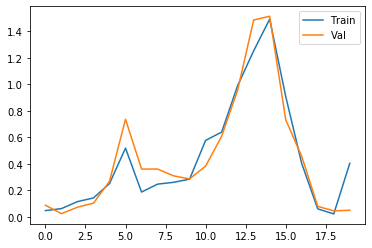

In [18]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Train', 'Val'])